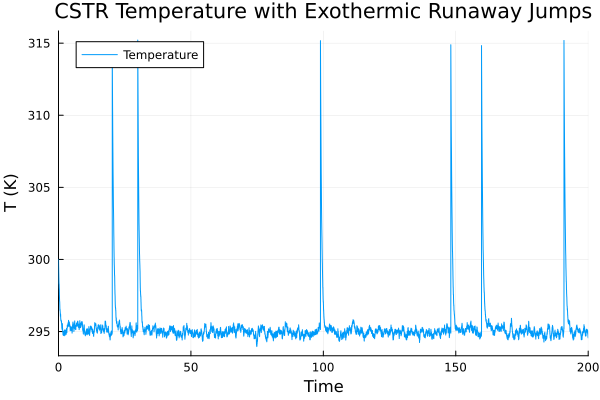

In [1]:
using DifferentialEquations
using Random
using Plots

# =========================
# CSTR + Heat Balance Params
# =========================

mutable struct CSTRParams
    F::Float64                # volumetric flow rate
    V::Float64                # reactor volume
    C_in::Float64             # inlet concentration
    T_in::Float64             # inlet temperature
    T_c::Float64              # coolant temperature

    k0::Float64               # pre-exponential factor
    E_over_R::Float64         # E/R (activation / gas constant)
    beta::Float64             # heat release coefficient (-ΔH/(ρCp))
    k_cool::Float64           # cooling coefficient UA/(ρCpV)

    sigma_C::Float64          # noise intensity for concentration
    sigma_T::Float64          # noise intensity for temperature

    ΔT_jump::Float64          # temperature jump size at failure
    τ_mean_fail::Float64      # mean quiescence time between failures
    next_jump::Float64        # absolute time of next failure
end

# Helper: sample exponential waiting time with mean τ_mean
exp_wait(τ_mean) = -τ_mean * log(rand())

# -------------------------
# Choose some example values
# -------------------------
F         = 1.0
V         = 1.0
C_in      = 1.0
T_in      = 300.0      # K
T_c       = 290.0      # K (coolant a bit colder)

k0        = 1.0e3      # 1/s
E_over_R  = 8000.0     # K
beta      = 2.0        # K per unit rate (lumped)
k_cool    = 1.0        # 1/s

sigma_C   = 0.0        # no concentration noise (for simplicity)
sigma_T   = 0.5        # temperature noise

ΔT_jump   = 20.0       # runaway: +20 K spike per failure
τ_mean_fail = 30.0     # mean time between failures (change this!)

# First failure scheduled from t = 0
p = CSTRParams(
    F, V, C_in, T_in, T_c,
    k0, E_over_R, beta, k_cool,
    sigma_C, sigma_T,
    ΔT_jump, τ_mean_fail,
    exp_wait(τ_mean_fail)  # next_jump
)

# =========================
# Drift (deterministic part)
# =========================
function drift!(du, u, p::CSTRParams, t)
    C = u[1]
    T = u[2]

    # Arrhenius rate
    r = p.k0 * exp(-p.E_over_R / T) * C

    # Material balance
    du[1] = (p.F / p.V) * (p.C_in - C) - r

    # Energy balance (lumped form)
    du[2] = (p.F / p.V) * (p.T_in - T) +
            p.beta * r -
            p.k_cool * (T - p.T_c)
end

# =========================
# Diffusion (stochastic part)
# =========================
function diffusion!(du, u, p::CSTRParams, t)
    du[1] = p.sigma_C
    du[2] = p.sigma_T
end

# =========================
# Jump / failure mechanism
# =========================

# Condition: trigger when t == p.next_jump
function jump_condition(u, t, integrator)
    t - integrator.p.next_jump
end

# Effect: runaway heat spike in T, then schedule next failure
function jump_affect!(integrator)
    # Apply exothermic runaway
    integrator.u[2] += integrator.p.ΔT_jump

    # Schedule the next failure
    τ = exp_wait(integrator.p.τ_mean_fail)
    integrator.p.next_jump = integrator.t + τ
end

jump_cb = ContinuousCallback(
    jump_condition,
    jump_affect!;
    save_positions = (true, true) # save before & after jump
)

# =========================
# Problem setup & solution
# =========================

# Initial state (slightly perturbed)
C0   = 1.0
T0   = 300.0
u0   = [C0, T0]

Tfinal = 200.0
tspan  = (0.0, Tfinal)
dt     = 0.01

prob = SDEProblem(drift!, diffusion!, u0, tspan, p)

sol = solve(
    prob,
    EM();
    dt = dt,
    callback = jump_cb
)

# =========================
# Plot: Temperature + Concentration
# =========================

plt2 = plot(sol.t, [u[2] for u in sol.u],
            xlabel = "Time",
            ylabel = "T (K)",
            label = "Temperature",
            title = "CSTR Temperature with Exothermic Runaway Jumps",
            xlims = (0, Tfinal),
            legend = true,
            grid = true)

display(plt2)
